# Process "Company Positions" Question Using a LLM

Andrew Weng, 12/30/2024

We are going to use a mixed LLM-Python approach to solve the problem of "user text categorization."

This problem can be decomposed into five steps:

1. Pre-process (LLM1)
 - Each user provides up to three keywords as a string. These keywords need to be normalized and stored in a large list of individual keywords for the next stage.
2. Define categories (LLM2)
 - With the list of keywords, find the best set of categories to describe the keywords
3. Assign categories (LLM3)
 - For each keyword, assign it to a category. Be careful about how to handle exceptions (e.g., a keyword that doesn't seem to belog into any particular category.)
4. Count occurences (Python)
 - Within each category, sum up the total number of keywords. 
5. Visualize the results (Python)

In [1]:
import os
import time

current_folder = os.path.basename(os.getcwd())
if current_folder == 'notebooks':
    root_path = os.path.dirname(os.path.abspath(''))
    os.chdir(root_path)

from src.analyst import Analyst
from src.plotter import Plotter
from src.llm import LLM

from collections import defaultdict

import pickle
from pprint import pprint

from IPython import get_ipython
# Automatically reload all modules every time a line of code is executed
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

# Initialize our helper classes

In [2]:
analyst = Analyst()
analyst.load_data()
analyst.build_respondents_list()

plotter = Plotter()
llm = LLM()

# Fetch the relevant dataset to analyze

In [3]:
working_list = [] # includes unemployed but previously working
working_and_recruiting_list = [] # those who are working and participate in recruiting
student_list = []

for respondent in analyst.respondents_list:

    if respondent.is_working or respondent.is_unemployed:

        working_list.append(respondent)

        if respondent.company['role_level'] in ['Senior', 'Expert', 'Manager', 'Director/VP', 'Executive']:
            working_and_recruiting_list.append(respondent)

    if respondent.is_student:
        student_list.append(respondent)

print(f'Number of working respondents: {len(working_list)}')
print(f'Number of working respondents who also participate in recruiting: {len(working_and_recruiting_list)}')
print(f'Number of student respondents: {len(student_list)}')

Number of working respondents: 937
Number of working respondents who also participate in recruiting: 487
Number of student respondents: 86


In [4]:
question = dict()
question['tag'] = 'company_skills_positions_hardest_to_fill'
question['question'] = "In your opinion, which positions are the hardest to fill in your company?"
question['categories'] = ['Executive Leadership / C-suite',
 'Middle Managers / Managers / Supervisors',
 'Battery Engineering / Cell Engineering',
 'Chemical / Electrochemical Engineering',
 'Electrical / Electronics Engineering',
 'Mechanical Engineering / Design',
 'Software Engineering / Developers',
 'Data Science / Machine Learning / AI',
 'Process / Systems Engineering',
 'Manufacturing and Production Roles',
 'Quality Assurance / Reliability / Testing',
 'Sales / Marketing / Business Development',
 'Technicians / Lab Technicians',
 'Research and Development (R&D)',
 'Project / Program Management',
 'Supply Chain / Logistics / Procurement',
 'Customer Support / Customer Success',
 'Human Resources / Administrative Roles',
 'Operations / Maintenance',
 'Education / Training',
 'Other Specialized Roles']


question['data'] = analyst.summarize_company_skills(working_and_recruiting_list)\
    ['hardest_to_fill_positions_list']


# Pre-process the user response

Interpret the delimiters

In [5]:
keyword_list = []

for i, string_of_list in enumerate(question['data']):
    print(f"Processing response {i+1} of {len(question['data'])}")
    list_of_strings = llm.delimit_string_of_list(string_of_list)
    print(f'--> {list_of_strings}\n')
    keyword_list.extend(list_of_strings)

# Assemble and cache the list
print(keyword_list)
timestamp = time.strftime('%Y%m%d_%H%M%S')
with open(f'data/strlist_{question['tag']}_recruiters_{timestamp}.pkl', 'wb') as f:
    pickle.dump(keyword_list, f)

Processing response 1 of 371
--> ['CEO', 'overnight production staff', 'middle level staff']

Processing response 2 of 371
--> []

Processing response 3 of 371
--> ['battery technical fellow']

Processing response 4 of 371
--> []

Processing response 5 of 371
--> ['CTO']

Processing response 6 of 371
--> ['product development - batteries']

Processing response 7 of 371
--> ['Front line manager']

Processing response 8 of 371
--> ['senior positions', 'expert positions']

Processing response 9 of 371
--> ['Manager départemental']

Processing response 10 of 371
--> ['Battery integration engineer']

Processing response 11 of 371
--> ['Product Management', 'Sales', 'Developers']

Processing response 12 of 371
--> ['Marketing', 'product management']

Processing response 13 of 371
--> ['Directors', 'Managers']

Processing response 14 of 371
--> ['CEO', 'SVP', 'VP']

Processing response 15 of 371
--> ['Director']

Processing response 16 of 371
--> ['subject matter experts']

Processing respons

# Define categories

In [6]:
if question['categories'] == []:

    categories = llm.define_categories(question['question'], keyword_list,
                                   num_categories=20)

    category_list = []
    for category in categories['categories']:
        category_list.append(category['name'])
else:
    category_list = question['categories']

pprint(category_list)

['Executive Leadership / C-suite',
 'Middle Managers / Managers / Supervisors',
 'Battery Engineering / Cell Engineering',
 'Chemical / Electrochemical Engineering',
 'Electrical / Electronics Engineering',
 'Mechanical Engineering / Design',
 'Software Engineering / Developers',
 'Data Science / Machine Learning / AI',
 'Process / Systems Engineering',
 'Manufacturing and Production Roles',
 'Quality Assurance / Reliability / Testing',
 'Sales / Marketing / Business Development',
 'Technicians / Lab Technicians',
 'Research and Development (R&D)',
 'Project / Program Management',
 'Supply Chain / Logistics / Procurement',
 'Customer Support / Customer Success',
 'Human Resources / Administrative Roles',
 'Operations / Maintenance',
 'Education / Training',
 'Other Specialized Roles']


# Assign categories

Process one keyword at a time!

In [7]:
content_list = []
other_list = []
fail_list = []

for i, keyword in enumerate(keyword_list):

    print(f"Processing response: '{keyword}' ({i+1} of {len(keyword_list)})...")

    try:
        output = llm.classify_user_response(category_list, keyword,
                                            model='gpt-4o')
    except: # JSON output fails
        fail_list.append(keyword)
        continue

    if output['result']['category'] in category_list:
        content_list.append(output)
    else:
        other_list.append(output)

Processing response: 'CEO' (1 of 675)...
Processing response: 'overnight production staff' (2 of 675)...
Processing response: 'middle level staff' (3 of 675)...
Processing response: 'battery technical fellow' (4 of 675)...
Processing response: 'CTO' (5 of 675)...
Processing response: 'product development - batteries' (6 of 675)...
Processing response: 'Front line manager' (7 of 675)...
Processing response: 'senior positions' (8 of 675)...
Processing response: 'expert positions' (9 of 675)...
Processing response: 'Manager départemental' (10 of 675)...
Processing response: 'Battery integration engineer' (11 of 675)...
Processing response: 'Product Management' (12 of 675)...
Processing response: 'Sales' (13 of 675)...
Processing response: 'Developers' (14 of 675)...
Processing response: 'Marketing' (15 of 675)...
Processing response: 'product management' (16 of 675)...
Processing response: 'Directors' (17 of 675)...
Processing response: 'Managers' (18 of 675)...
Processing response: 'CEO'

In [8]:
print(len(other_list))

74


In [9]:
other_list

[{'result': {'response_text': 'expert positions', 'category': 'Other'}},
 {'result': {'response_text': 'subject matter experts', 'category': 'Other'}},
 {'result': {'response_text': 'Talking engineers', 'category': 'Other'}},
 {'result': {'response_text': 'fp&a with domain knowledge',
   'category': 'Other'}},
 {'result': {'response_text': 'technical roles', 'category': 'Other'}},
 {'result': {'response_text': 'SLT', 'category': 'Other'}},
 {'result': {'response_text': 'Engineering', 'category': 'Other'}},
 {'result': {'response_text': 'Safety Engineer', 'category': 'Other'}},
 {'result': {'response_text': 'Consultant', 'category': 'Other'}},
 {'result': {'response_text': 'industry specialist 1', 'category': 'Other'}},
 {'result': {'response_text': 'FUSA engineer', 'category': 'Other'}},
 {'result': {'response_text': 'competent and well rounded',
   'category': 'Other'}},
 {'result': {'response_text': 'Broad knowledge', 'category': 'Other'}},
 {'result': {'response_text': 'Engineering'

In [10]:
print(len(fail_list))

0


## Assembly dictionary for plotting and a 'collection' dictionary

The 'collection' is a reference for which keywords got sorted into which categories.

In [11]:

collection = defaultdict(list)
counter    = defaultdict(int)

for content in content_list:

    category = content['result']['category']
    response = content['result']['response_text']
    counter[category] += 1
    collection[category].append(response)

counter['_tot_'] = len(question['data'])
counter

defaultdict(int,
            {'Executive Leadership / C-suite': 82,
             'Manufacturing and Production Roles': 44,
             'Middle Managers / Managers / Supervisors': 26,
             'Battery Engineering / Cell Engineering': 53,
             'Project / Program Management': 43,
             'Sales / Marketing / Business Development': 71,
             'Software Engineering / Developers': 35,
             'Data Science / Machine Learning / AI': 13,
             'Process / Systems Engineering': 27,
             'Quality Assurance / Reliability / Testing': 29,
             'Mechanical Engineering / Design': 16,
             'Chemical / Electrochemical Engineering': 23,
             'Technicians / Lab Technicians': 33,
             'Customer Support / Customer Success': 6,
             'Research and Development (R&D)': 37,
             'Education / Training': 3,
             'Electrical / Electronics Engineering': 29,
             'Supply Chain / Logistics / Procurement': 10,
 

In [12]:
collection

defaultdict(list,
            {'Executive Leadership / C-suite': ['CEO',
              'CTO',
              'senior positions',
              'Directors',
              'CEO',
              'SVP',
              'VP',
              'Director',
              'Senior technical leader',
              'CFO',
              'CTO',
              'Executive Leadership',
              'CFO',
              'execs with actual battery making experience',
              'COO',
              'Senior staff engineers',
              'leadership',
              'Executive',
              'Director',
              'engineering leaders',
              'CTO',
              'Top management',
              'head of business unit',
              'Head of product',
              'Engineering Lead',
              'Co-founder',
              'CTO',
              'Leadership',
              'Leadership roles',
              'Director',
              'VP',
              'service leadership',
              'executiv

# Visualize the results

In [13]:
collection['Other Specialized Roles']

[]

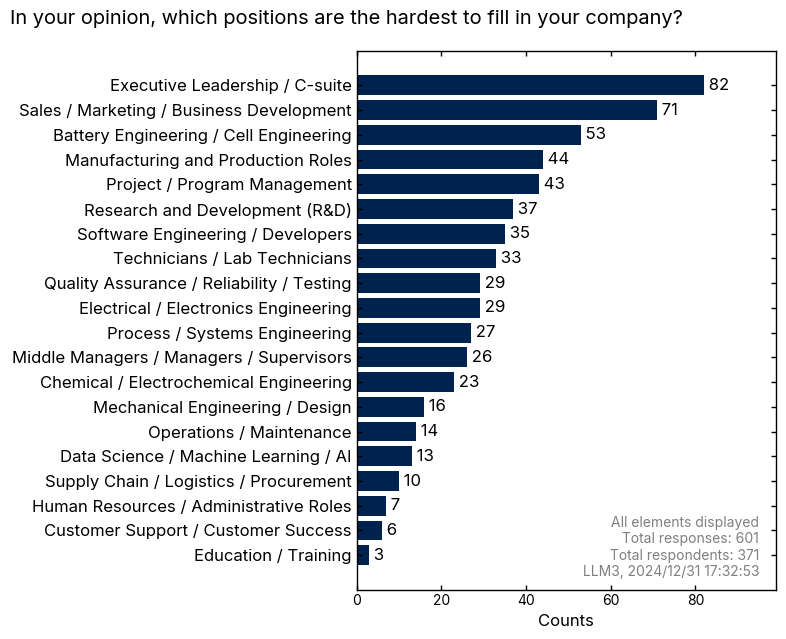

In [14]:
plotter.make_bar_plot_from_dict(counter,
                                title=question['question'],
                                sorted=True,
                                annotation=f'LLM3, {time.strftime("%Y/%m/%d %H:%M:%S")}',
                                num_elements=100,
                                exclusions=['Other Specialized Roles'],
                                saveas=f'{question['tag']}_recruiters_{time.strftime("%Y%m%d_%H%M%S")}.png'
)